In [84]:
import itertools
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, date, timedelta
from math import log

# visualization
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline

import xgboost as xgb
from catboost import CatBoostClassifier, Pool, cv
import hyperopt
from numpy.random import RandomState
from scipy.stats import uniform

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
# model evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

# classifiers
from sklearn.naive_bayes import GaussianNB # naive bayes
from sklearn.neighbors import KNeighborsClassifier # KNN
from sklearn.linear_model import LogisticRegression # logistic regression
from sklearn.tree import DecisionTreeClassifier # decision Tree
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import GradientBoostingClassifier

In [97]:
#Import data
xtrain = pd.read_csv("Xtrain.csv")
ytrain = pd.read_csv("Ytrain.csv")
records = xtrain.copy()
records['ChargeOff'] = ytrain['ChargeOff']
print(records.dtypes)
print(records.shape)

Id                     int64
Name                  object
City                  object
State                 object
Zip                    int64
Bank                  object
BankState             object
NAICS                  int64
ApprovalDate          object
ApprovalFY            object
Term                   int64
NoEmp                  int64
NewExist             float64
CreateJob              int64
RetainedJob            int64
FranchiseCode          int64
UrbanRural             int64
RevLineCr             object
LowDoc                object
DisbursementDate      object
DisbursementGross     object
BalanceGross          object
GrAppv                object
SBA_Appv              object
ChargeOff              int64
dtype: object
(50000, 25)


### Data Prepocessing
- removal of nan value affect the accuracy negatively

In [98]:
#To find and remove duplicate rows
#records.drop( records[records.duplicated()].index, axis=0, inplace=True )
records = records.drop(columns=['Id', 'Name', 'BalanceGross'])
def clean_dirty_data(records):
    ids_to_remove = set()
    for index, row in records.iterrows():
        if row['LowDoc'] not in ('Y', 'N'):
            ids_to_remove.add(index)
    print(f'# of ids removed: {len(ids_to_remove)}')
    records = records.drop(list(ids_to_remove))
    return records
# records = clean_dirty_data(records)

### Data Transformation

In [99]:
#Reformatting numeric columns and datetime columns
categorical_features_indices = ['City', 'State', 'Zip', 'Bank', 'BankState', 'NAICS', 'ApprovalDate', 'ApprovalFY', 
                                'NewExist', 'FranchiseCode', 'UrbanRural', 'RevLineCr', 'LowDoc', 'DisbursementDate', 'Recession']

NAICS_TO_INDUSTRY = {
    '11': 'AGS',
    '21': 'MINING',
    '22': 'UTILITIES',
    '23': 'CONSTRUCTION',
    '31': 'MANUFACTURING',
    '32': 'MANUFACTURING',
    '33': 'MANUFACTURING',
    '42': 'WHOLESALE_TRADE',
    '44': 'RETAIL_TRADE',
    '45': 'RETAIL_TRADE',
    '48': 'TRANSPORTATION_WAREHOUSING',
    '49': 'TRANSPORTATION_WAREHOUSING',
    '51': 'INFORMATION',
    '52': 'FINANCE_INSURANCE',
    '53': 'REAL_ESTATE',
    '54': 'SERVICES',
    '55': 'MANAGEMENT',
    '56': 'ADMIN',
    '61': 'EDU',
    '62': 'HEALTHCARE',
    '71': 'ENTERTAINMENT',
    '72': 'ACCOMMODATION_FOOD',
    '81': 'OTHER_SERVICES',
    '92': 'PUBLIC_ADMIN'
}

RECESSION_PERIODS = [[date(1990, 7, 1), date(1991, 3, 1)],
                     [date(2001, 3, 1), date(2001, 11, 1)],
                     [date(2007, 12, 1), date(2009, 6, 1)]]


def with_in_recession(row):
    # load is labeled as 'Y' for Recession if the load is active for at least a month during the Recession time frame
    try:
        raw_disbursement_date = str(row['DisbursementDate'])
        if not pd.isnull(raw_disbursement_date):
            disbursement_date = datetime.strptime(raw_disbursement_date.strip(), '%d-%b-%y').date()
            term = int(row['Term']) if not pd.isnull(row['Term']) else 0
            recession = False
            for period in RECESSION_PERIODS:
#                 if period[0] <= disbursement_date + timedelta(days=term*30) <= period[1]:
                if (disbursement_date <= period[0] and
                    period[0] + timedelta(days=30) <= disbursement_date + timedelta(days=term*30)) or \
                        (period[0] <= disbursement_date <= period[1] and
                         disbursement_date + timedelta(days=30) <= period[1]):
                    recession = True
                    break
            return 'Y' if recession else 'N'
        else:
            return 'N'
    except:
        return 'N'

def fill_disbursement_date(row):
    try:
        if pd.isnull(row['DisbursementDate']) and not pd.isnull(row['ApprovalDate']):
            return row['ApprovalDate']
        else:
            return ''
    except:
        return ''
    

def data_transformation(records):
    # existing columns
    records['Zip'] = records['Zip'].apply(lambda x: str(x))
    records['Bank'] = records['Bank'].apply(lambda x: 'Unknown' if pd.isnull(x) else x)
    records['BankState'] = records['BankState'].apply(lambda x: 'Unknown' if pd.isnull(x) else x)
    records["NAICS"] = records['NAICS'].apply(lambda x: NAICS_TO_INDUSTRY.get(str(x)[0:2], 'NONE') if len(str(x)) >= 2 else 'NONE')
    records["ApprovalFY"] = records['ApprovalFY'].apply(lambda x: str(x).replace('A', '').strip() if re.match(r'^\d{4}A$', str(x).strip()) else x)
    records['FranchiseCode'] = records['FranchiseCode'].apply(lambda x: 'N' if x in ['0', '1', 0, 1] else 'Y')
    records['NewExist'] = records['NewExist'].apply(lambda x: str(x) if not pd.isnull(x) else '0.0')
    records['DisbursementGross'] = records['DisbursementGross'].apply(lambda x: float(str(x).replace('$', '').replace(',', '').strip()))
    records['GrAppv'] = records['GrAppv'].apply(lambda x: float(str(x).replace('$', '').replace(',', '').strip()))
    records['SBA_Appv'] = records['SBA_Appv'].apply(lambda x: float(str(x).replace('$', '').replace(',', '').strip()))
    records['LowDoc'] = records['LowDoc'].apply(lambda x: 'Undefined' if pd.isnull(x) or str(x).strip() not in ('Y', 'N') else x)
    records['DisbursementDate'] = records.apply(fill_disbursement_date, axis=1)
    records['RevLineCr'] = records['RevLineCr'].map({'Y': 'Y', 'N': 'N',  
                                                     '0': 'N', 0: 'N', 'T': 'Y', np.nan: 'N'})
    
    # new columns
    records['Recession'] = records.apply(with_in_recession, axis=1)
    records['Ratio'] = records['DisbursementGross'] / records['GrAppv']
    
    return records
records = data_transformation(records)

for col in records:
    dt = records[col].dtype 
    if dt == int or dt == float:
        records[col].fillna(0, inplace=True)
    else:
        records[col].fillna("", inplace=True)


def cat_feature_encoding(records):
    label_encoder = LabelEncoder()
#     one_hot_encoder = OneHotEncoder(sparse=False, categories='auto')
    for col in categorical_features_indices:
        feature = label_encoder.fit_transform(records[col].apply(lambda x: str(x)))
#         feature = feature.reshape(records.shape[0], 1)
        records[col] = feature
    return records


records = cat_feature_encoding(data_transformation(records))
records.reset_index(drop=True, inplace=True)
records.head()

,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,Term,NoEmp,...,UrbanRural,RevLineCr,LowDoc,DisbursementDate,DisbursementGross,GrAppv,SBA_Appv,ChargeOff,Recession,Ratio
0,6765,9,3772,2372,8,0,1585,41,130,25,...,1,0,0,0,2000000.0,2000000.0,1500000.0,0,0,1.0000
1,7382,44,11442,2783,45,0,5299,41,33,6,...,1,0,0,0,17000.0,17000.0,17000.0,1,0,1.0000
2,4670,4,12029,210,27,0,4868,33,60,1,...,1,1,0,0,17000.0,17000.0,8500.0,0,0,1.0000
3,4628,48,6842,168,50,0,322,25,160,1,...,0,0,0,0,137000.0,137000.0,123300.0,0,0,1.0000
4,4487,24,8646,653,24,0,6081,37,101,2,...,1,1,0,0,46665.0,25000.0,12500.0,0,0,1.8666


In [6]:
# records[ (records['Ratio']> 1.0) & (records.RevLineCr == 'N' )]

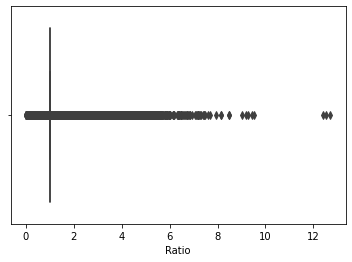

In [7]:
sb.boxplot(x=records['Ratio'])

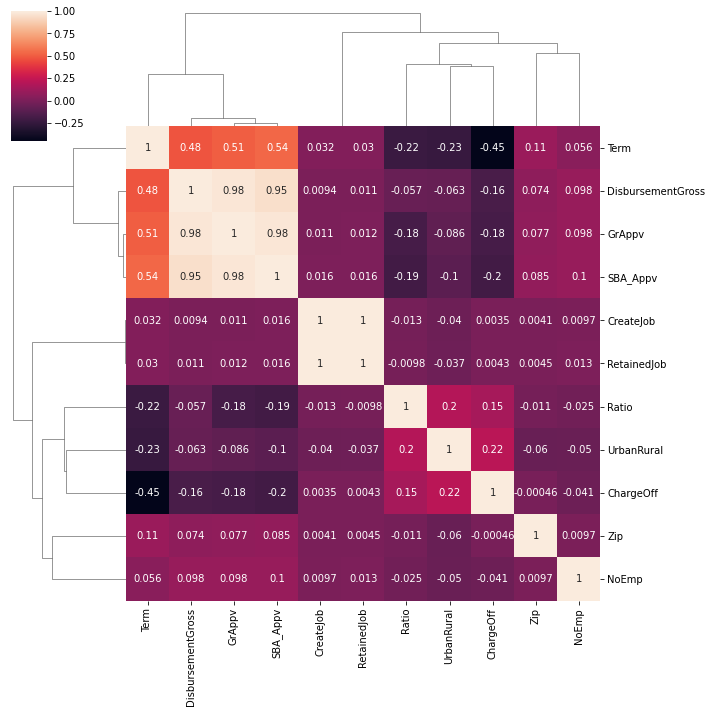

In [5]:
sb.clustermap(records.corr(), annot=True)

   Recession  ChargeOff
3          Y          0
8          Y          0
13         Y          1
15         Y          0
16         Y          1


<AxesSubplot:xlabel='ChargeOff', ylabel='count'>

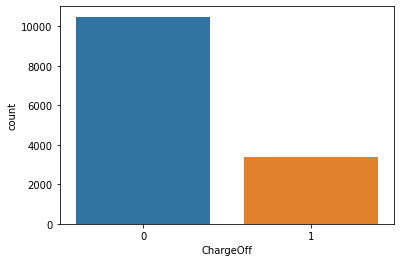

In [6]:
default_records = pd.DataFrame()
default_records['Recession'] = records.query('Recession == "Y"')['Recession']
default_records['ChargeOff'] = records.query('Recession == "Y"')['ChargeOff']
print(default_records.head())
sb.countplot(x='ChargeOff', data=default_records)

In [100]:
x1 = records.drop(columns='ChargeOff')
y1 = records['ChargeOff']
x_train, x_test, y_train, y_test = train_test_split(x1, y1, test_size = 0.25, random_state=0)

### Train model
- the choice of categofical features matters

In [107]:
d = {}
for i in range(100, 305, 5):
    model = xgb.XGBClassifier(objective='binary:logistic', 
                          n_estimators=i,
                          learning_rate=0.20914331424002888)
    model.fit(x_train, y_train)
    preds = model.predict(x_test)
    acc = round(accuracy_score(y_test, preds) * 100, 2)
    print(f'n_estimators: {i}, accurancy: {acc}')
    d[i] = acc

n_estimators: 100, accurancy: 92.86
n_estimators: 105, accurancy: 92.99
n_estimators: 110, accurancy: 92.98
n_estimators: 115, accurancy: 92.98
n_estimators: 120, accurancy: 92.95
n_estimators: 125, accurancy: 92.91
n_estimators: 130, accurancy: 92.88
n_estimators: 135, accurancy: 92.83
n_estimators: 140, accurancy: 92.82
n_estimators: 145, accurancy: 92.84
n_estimators: 150, accurancy: 92.89
n_estimators: 155, accurancy: 92.8
n_estimators: 160, accurancy: 92.82
n_estimators: 165, accurancy: 92.89
n_estimators: 170, accurancy: 92.9
n_estimators: 175, accurancy: 92.96
n_estimators: 180, accurancy: 92.93
n_estimators: 185, accurancy: 92.93
n_estimators: 190, accurancy: 92.94
n_estimators: 195, accurancy: 92.99
n_estimators: 200, accurancy: 93.09
n_estimators: 205, accurancy: 93.11
n_estimators: 210, accurancy: 93.18
n_estimators: 215, accurancy: 93.14
n_estimators: 220, accurancy: 93.18
n_estimators: 225, accurancy: 93.17
n_estimators: 230, accurancy: 93.14
n_estimators: 235, accurancy: 

In [ ]:
next(((k,v) for k, v in d.items() if v == max(d.values())), None)

In [106]:
# run with xgboost
d_train = xgb.DMatrix(x_train, label=y_train)
d_test = xgb.DMatrix(x_test, label=y_test)
model = xgb.XGBClassifier(objective='binary:logistic', 
                          n_estimators=135,
                          learning_rate=0.20914331424002888)
model.fit(x_train, y_train)
preds = model.predict(x_test)
f1 = round(f1_score(y_test, preds, average='weighted') * 100, 2)
acc = round(accuracy_score(y_test, preds) * 100, 2)

print(f"prediction with the best model: accuracy: {acc}, weighted F1: {f1}")

prediction with the best model: accuracy: 92.83, weighted F1: 92.83


### Train model with best params

In [79]:
gsc = GridSearchCV(estimator=xgb.XGBClassifier(objective='binary:logistic'),
                   param_grid={'n_estimators': [i for i in range(50, 255, 5)],
                               'max_depth': [i for i in range(4, 34, 2)],
                               'learning_rate': [i for i in np.arange(0.003, 0.3, 0.01)],
                               'gamma': [i for i in np.arange(0, 0.55, 0.05)],
                               'subsample': [i for i in np.arange(0.2, 1.2, 0.2)],
                               'colsample_bytree': [i for i in np.arange(0.2, 1.2, 0.2)],
                               'min_child_weight': [i for i in range(1, 11, 1)]
                              },
                   cv=10, scoring='accuracy', verbose=0)
best_model = gsc.fit(x_train, y_train)

KeyboardInterrupt: 

In [104]:
def hyperopt_objective(params):
    model = xgb.XGBClassifier(n_estimators = params['n_estimators'],
#                               max_depth = int(params['max_depth']),
                              learning_rate = params['learning_rate'],
#                               gamma = params['gamma'],
#                               min_child_weight = params['min_child_weight'],
#                               subsample = params['subsample'],
#                               colsample_bytree = params['colsample_bytree']
                             )
    
    model.fit(x_train, y_train)

    accuracies = cross_val_score(estimator=model, X=x_train, y=y_train, cv=10)
    CrossValMean = accuracies.mean()

    return{'loss':1-CrossValMean, 'status': hyperopt.STATUS_OK }

In [105]:
params_space = {
    'learning_rate': hyperopt.hp.uniform('learning_rate', 1e-3, 5e-1),
#     'max_depth' : hyperopt.hp.choice('max_depth', range(5, 30, 1)),
    'n_estimators' : hyperopt.hp.choice('n_estimators', range(20, 205, 5)),
#     'gamma' : hyperopt.hp.quniform('gamma', 0, 0.50, 0.01),
#     'min_child_weight' : hyperopt.hp.quniform('min_child_weight', 1, 10, 1),
#     'subsample' : hyperopt.hp.quniform('subsample', 0.1, 1, 0.01),
#     'colsample_bytree' : hyperopt.hp.quniform('colsample_bytree', 0.1, 1.0, 0.01)    
}

trials = hyperopt.Trials()

best = hyperopt.fmin(
    hyperopt_objective,
    space=params_space,
    algo=hyperopt.tpe.suggest,
    max_evals=50,
    trials=trials
)

print(best)
# {'colsample_bytree': 0.88, 'gamma': 0.0, 'learning_rate': 0.12081443556621764, 'max_depth': 11, 'min_child_weight': 6.0, 'n_estimators': 17, 'subsample': 0.91}

100%|██████████| 50/50 [1:09:03<00:00, 82.87s/trial, best loss: 0.06954666666666642] 
{'learning_rate': 0.20914331424002888, 'n_estimators': 23}


In [53]:
model = xgb.XGBClassifier(n_estimators = best['n_estimators'],
                      max_depth = best['max_depth'],
                      learning_rate = best['learning_rate'],
                      gamma = best['gamma'],
                      min_child_weight = best['min_child_weight'],
                      subsample = best['subsample'],
                      colsample_bytree = best['colsample_bytree']
                      )
model.fit(x_train, y_train)
preds = model.predict(x_test)
f1 = round(f1_score(y_test, preds, average='weighted') * 100, 2)
acc = round(accuracy_score(y_test, preds) * 100, 2)

print(f"prediction with the best model: accuracy: {acc}, weighted F1: {f1}")

prediction with the best model: accuracy: 92.01, weighted F1: 92.01


### Predict

In [34]:
X_test = pd.read_csv('Xtest.csv')

In [35]:
X_testset = X_test.drop(['Id', 'Name', 'BalanceGross'], axis=1)
for col in X_testset:
    dt = X_testset[col].dtype 
    if dt == int or dt == float:
        X_testset[col].fillna(0, inplace=True)
    else:
        X_testset[col].fillna("", inplace=True)

In [36]:
#Reformatting numeric columns and datetime columns
X_testset = data_transformation(X_testset)
X_testset = cat_feature_encoding(X_testset)
# X_testset['DisbursementGross'] = X_testset['DisbursementGross'].apply(lambda x: float(x.replace('$', '').replace(',', '').strip()))
# X_testset['GrAppv'] = X_testset['GrAppv'].apply(lambda x: float(x.replace('$', '').replace(',', '').strip()))
# X_testset['SBA_Appv'] = X_testset['SBA_Appv'].apply(lambda x: float(x.replace('$', '').replace(',', '').strip()))
# X_testset['Ratio'] = X_testset['DisbursementGross'] / X_testset['GrAppv']

In [37]:
import pandas as pd
submisstion = pd.DataFrame()
submisstion['Id'] = X_test['Id']
submisstion['ChargeOff'] = model.predict(X_testset)

In [38]:
submisstion.to_csv('submission.csv', index=False)